In [133]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy.stats as stats

mpl.rc('font', family='Malgun Gothic')

In [134]:
# 반도체 공정 (8대)
# 'Target' : 하나의 Wafer 판에 발생하는 불량 Chip 개수 / 2000개 -> 회귀 Model
# 'target_binom' : Wafer 폐기 여부 / (Wafer 폐기 / 정상) -> 분류 Model
df1 = pd.read_csv('11_Data.csv')
df1.info()  # Row : 752 / Columns : 60

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 752 entries, 0 to 751
Data columns (total 60 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           752 non-null    int64  
 1   Ox_Chamber           752 non-null    int64  
 2   process              752 non-null    object 
 3   type                 752 non-null    object 
 4   Temp_OXid            752 non-null    float64
 5   Vapor                752 non-null    object 
 6   ppm                  752 non-null    float64
 7   Pressure             752 non-null    float64
 8   Oxid_time            752 non-null    float64
 9   thickness            752 non-null    float64
 10  No_Die               752 non-null    object 
 11  Reinforcement        752 non-null    bool   
 12  Unnamed: 0_x         752 non-null    int64  
 13  photo_soft_Chamber   752 non-null    int64  
 14  process 2            752 non-null    object 
 15  resist_target        752 non-null    flo

# 목표

- 'Target' : 불량 Chip의 개수를 예측
- Column 매우 많아서 'Target'를 예측하기 위한 적절한 X를 선택한 뒤 Model 생성
- 머신러닝 분석 전략
    - 1. Lasso : 목표변수 Y에 영향이 크지 않은 설명변수 X를 제외하여 회귀식을 구성 (규제)
        - 규제 선형 회귀 -> X 연속형 변수

    - 2. Tree : 앞서 선택된 (제외되지 않은) X와 Y를 학습해 Model 생성
        - 범주형 모델은 앞서 선택된 연속형 모델들과 함께 2번단계에서 추가 / 학습

In [135]:
df1.describe()

,Unnamed: 0,Ox_Chamber,Temp_OXid,ppm,Pressure,Oxid_time,thickness,Unnamed: 0_x,photo_soft_Chamber,resist_target,N2_HMDS,pressure_HMDS,temp_HMDS,temp_HMDS_bake,time_HMDS_bake,spin1,spin2,spin3,photoresist_bake,temp_softbake,time_softbake,lithography_Chamber,Line_CD,Wavelength,Resolution,Energy_Exposure,Unnamed: 0_y,Etching_Chamber,Temp_Etching,Source_Power,Selectivity,Thin Film 4,Thin Film 3,Thin Film 2,Thin Film 1,Etching_rate,Chamber_Num,Flux60s,Flux90s,Flux160s,Flux480s,Flux840s,input_Energy,Temp_implantation,Furance_Temp,RTA_Temp,Target,target_binom
count,752.000000,752.00000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.00000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,7.520000e+02,7.520000e+02,7.520000e+02,7.520000e+02,7.520000e+02,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000
mean,418.373670,1.99867,1065.571301,33.340997,0.211352,123.414894,711.100386,418.373670,2.002660,0.971488,15.86115,15.005245,19.999481,200.643573,90.000066,500.877714,4024.407977,5017.281172,5.017618,91.934847,30.000722,2.001330,41.059233,404.109043,516.007390,108.122616,418.373670,1.977394,71.160335,51.241596,1.032472,315.376330,330.068431,366.603311,423.746330,2.709250,1.977394,1.198926e+16,8.200466e+16,4.587119e+17,3.002307e+17,5.999997e+17,31987.598380,103.187367,900.381649,154.726064,112.070479,0.085106
std,246.420678,0.81022,146.947001,8.363135,0.009225,74.582482,8.039889,246.420678,0.819206,0.172075,2.15047,0.079364,0.003692,2.869695,0.000776,2.908263,55.869867,69.282836,0.070141,1.472703,0.006304,0.829707,11.746344,28.743622,26.655657,1.533999,246.420678,0.829400,0.822335,0.636492,0.016104,114.922683,115.213777,115.268630,115.283978,0.025163,0.829400,4.573631e+15,5.451701e+16,3.312285e+17,1.148667e+15,1.074685e+12,599.620772,1.653894,18.837290,2.411018,61.835348,0.279226
min,0.000000,1.00000,862.011276,21.740000,0.180000,8.000000,681.435000,0.000000,1.000000,0.500000,9.49700,14.776000,19.986000,191.209000,89.998000,492.196000,3879.656000,4814.620000,4.827000,86.498000,29.982000,1.000000,4.562000,365.000000,441.717000,103.407000,0.000000,1.000000,68.150000,49.342000,0.984000,151.000000,164.010000,200.420000,257.630000,2.639500,1.000000,1.967326e+15,3.846247e+09,4.394693e+00,2.963401e+17,5.999965e+17,29604.262000,97.744000,854.000000,148.000000,0.000000,0.000000
25%,202.750000,1.00000,875.154863,22.487500,0.205000,58.750000,706.125250,202.750000,1.000000,0.851224,14.52000,14.952750,19.997000,198.698500,90.000000,498.962500,3985.830750,4968.447250,4.968000,91.024250,29.997000,1.000000,31.920000,365.000000,499.847500,107.071000,202.750000,1.000000,70.689500,50.805750,1.022000,221.000000,235.150000,271.595000,328.865000,2.690500,1.000000,8.719445e+15,3.661555e+16,1.608614e+17,2.994454e+17,5.999990e+17,31613.971500,102.091500,888.000000,153.000000,75.000000,0.000000
50%,413.500000,2.00000,1070.564398,33.570000,0.213000,116.000000,711.640500,413.500000,2.000000,0.938198,16.16650,15.005000,20.000000,200.692000,90.000000,500.918000,4024.980500,5018.623500,5.020500,92.009000,30.001000,2.000000,40.424500,405.000000,514.895500,108.268500,413.500000,2.000000,71.219500,51.259000,1.034000,299.000000,314.145000,350.795000,407.970000,2.708625,2.000000,1.181942e+16,8.518472e+16,4.644915e+17,3.002608e+17,5.999997e+17,32199.080500,103.328500,903.000000,155.000000,101.000000,0.000000
75%,632.750000,3.00000,1183.584682,40.232500,0.218000,216.000000,716.017750,632.750000,3.000000,1.082972,17.13000,15.059000,20.002000,202.758250,90.001000,503.159000,4065.971500,5069.759000,5.068000,92.935750,30.005000,3.000000,49.866000,436.000000,539.003000,109.221500,632.750000,3.000000,71.689000,51.699250,1.043000,386.000000,400.140000,436.575000,493.782500,2.725000,3.000000,1

In [136]:
# 판다스의 축약되어 숨겨진 columns을 볼 때 사용
pd.options.display.max_columns = 100

In [137]:
df1.columns

Index(['Unnamed: 0', 'Ox_Chamber', 'process', 'type', 'Temp_OXid', 'Vapor',
       'ppm', 'Pressure', 'Oxid_time', 'thickness', 'No_Die', 'Reinforcement',
       'Unnamed: 0_x', 'photo_soft_Chamber', 'process 2', 'resist_target',
       'N2_HMDS', 'pressure_HMDS', 'temp_HMDS', 'temp_HMDS_bake',
       'time_HMDS_bake', 'spin1', 'spin2', 'spin3', 'photoresist_bake',
       'temp_softbake', 'time_softbake', 'lithography_Chamber', 'Line_CD',
       'UV_type', 'Wavelength', 'Resolution', 'Energy_Exposure', 'Range_check',
       'Unnamed: 0_y', 'Etching_Chamber', 'Process 3', 'Temp_Etching',
       'Source_Power', 'Selectivity', 'Thin Film 4', 'Thin Film 3',
       'Thin Film 2', 'Thin Film 1', 'Etching_rate', 'Chamber_Num', 'process4',
       'Flux60s', 'Flux90s', 'Flux160s', 'Flux480s', 'Flux840s',
       'input_Energy', 'Temp_implantation', 'Furance_Temp', 'RTA_Temp',
       'Target', 'Error_message', 'target_binom', 'Chamber_Route'],
      dtype='object')

In [138]:
df2 = df1.drop(columns=['Unnamed: 0', 'Ox_Chamber', 'Unnamed: 0_x', 'photo_soft_Chamber', 
                      'Unnamed: 0_y', 'Etching_Chamber', 'Chamber_Num', 'lithography_Chamber'])

In [139]:
df3 = df2[df2.describe().columns.to_list()]   # describe를 사용하여 숫자데이터 columns만 보고 리스트로 만들어 그것들만 추출

In [140]:
X = df3.drop(columns=['Target', 'target_binom'])
Y = df3['Target']

In [141]:
from sklearn.model_selection import train_test_split    # 학습데이터와 검증데이터 분할
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

In [142]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, random_state = 1234)

In [143]:
model_pipe = make_pipeline(SimpleImputer(), StandardScaler(), Lasso())
grid_model = GridSearchCV(model_pipe, cv=3, param_grid={}, n_jobs=-1)
grid_model.fit(X_train, Y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('standardscaler', StandardScaler()),
                                       ('lasso', Lasso())]),
             n_jobs=-1, param_grid={})

In [144]:
best_model = grid_model.best_estimator_

In [145]:
best_model['lasso'] # 파이프 내 학습 알고리즘만 따로 추출

Lasso()

In [146]:
best_model['lasso'].coef_   # 각 항목의 회귀 계수

array([-4.47357704, -6.38510869, 12.12026982,  3.09053272,  5.11369492,
        5.89626536,  0.        , -0.92627551,  0.        , -1.54392463,
       -1.57195575, -0.        , -2.25801411, -0.        , -0.        ,
       -2.30798733, -0.68747416,  3.6167978 ,  0.        , -3.68324304,
       -0.90890868,  2.30516931,  0.        ,  0.38330634, 14.35126807,
        0.        , 16.10344108,  0.        , 20.66892491, -0.        ,
       -4.0533188 , -3.65339334, -1.07257032, -0.        ,  1.32629451,
       -0.        ,  0.35529012,  0.05917127])

In [147]:
best_model['lasso'].intercept_  # 절편 intercept_

111.7003546098997

In [148]:
# Lasso 알고리즘에 의해, 회귀 계수가 적은 값을 제외
df_coef = pd.DataFrame(data=best_model['lasso'].coef_, columns=['Weight'])
df_coef['X_Feature'] = X.columns.values

df_coef

,Weight,X_Feature
0,-4.473577,Temp_OXid
1,-6.385109,ppm
2,12.120270,Pressure
3,3.090533,Oxid_time
4,5.113695,thickness
5,5.896265,resist_target
6,0.000000,N2_HMDS
7,-0.926276,pressure_HMDS
8,0.000000,temp_HMDS
9,-1.543925,temp_HMDS_bake


In [149]:
df_coef.sort_values(by='Weight', ascending=False)

,Weight,X_Feature
28,20.668925,Etching_rate
26,16.103441,Thin Film 2
24,14.351268,Thin Film 4
2,12.120270,Pressure
5,5.896265,resist_target
4,5.113695,thickness
17,3.616798,Line_CD
3,3.090533,Oxid_time
21,2.305169,Temp_Etching
34,1.326295,input_Energy


In [150]:
cond1 = (df_coef['Weight'] >= 5) | (df_coef['Weight'] <= -5)
df_coef.loc[cond1]


,Weight,X_Feature
1,-6.385109,ppm
2,12.120270,Pressure
4,5.113695,thickness
5,5.896265,resist_target
24,14.351268,Thin Film 4
26,16.103441,Thin Film 2
28,20.668925,Etching_rate


In [151]:
cond2 = (df_coef['Weight'] != 0)
df_select = df_coef.loc[cond2]
select_list = df_select['X_Feature'].values.tolist()
select_list
# 회귀 계수가 유의미 하지 않은 (Y, Target값에 크게 영향을 주지 않는) 변수를 제외하고
# 분석에 필요한 (회귀계수가 유의미한) 변수만 리스트 형태로 남김

['Temp_OXid',
 'ppm',
 'Pressure',
 'Oxid_time',
 'thickness',
 'resist_target',
 'pressure_HMDS',
 'temp_HMDS_bake',
 'time_HMDS_bake',
 'spin2',
 'temp_softbake',
 'time_softbake',
 'Line_CD',
 'Resolution',
 'Energy_Exposure',
 'Temp_Etching',
 'Selectivity',
 'Thin Film 4',
 'Thin Film 2',
 'Etching_rate',
 'Flux90s',
 'Flux160s',
 'Flux480s',
 'input_Energy',
 'Furance_Temp',
 'RTA_Temp']

In [152]:
select_list.append('UV_type')
select_list.append('type')

In [153]:
from sklearn.tree import DecisionTreeRegressor


In [154]:
X = df2[select_list]
Y = df2['Target']

## 새롭게 지정

In [155]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, random_state=1234)

In [156]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score, mean_squared_error


In [157]:
numeric_pipe = make_pipeline(SimpleImputer(), StandardScaler())
category_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder())

In [158]:
from sklearn.compose import make_column_transformer

In [159]:
numeric_list = X.describe().columns.tolist()
category_list = X.describe(include='object').columns.tolist()

preprocessing_pipe = make_column_transformer((numeric_pipe, numeric_list), (category_pipe, category_list))

In [160]:
model_pipe = make_pipeline(preprocessing_pipe, DecisionTreeRegressor())

In [161]:
help(DecisionTreeRegressor)

Help on class DecisionTreeRegressor in module sklearn.tree._classes:

class DecisionTreeRegressor(sklearn.base.RegressorMixin, BaseDecisionTree)
 |  DecisionTreeRegressor(*, criterion='squared_error', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, ccp_alpha=0.0)
 |  
 |  A decision tree regressor.
 |  
 |  Read more in the :ref:`User Guide <tree>`.
 |  
 |  Parameters
 |  ----------
 |  criterion : {"squared_error", "friedman_mse", "absolute_error",             "poisson"}, default="squared_error"
 |      The function to measure the quality of a split. Supported criteria
 |      are "squared_error" for the mean squared error, which is equal to
 |      variance reduction as feature selection criterion and minimizes the L2
 |      loss using the mean of each terminal node, "friedman_mse", which uses
 |      mean squared error with Friedman's improv

In [162]:
hyperparameter_list = {'decisiontreeregressor__max_depth' : range(5,10),
                        'decisiontreeregressor__min_samples_split' : range(5,10),
                        'decisiontreeregressor__min_samples_leaf' : range(5,10)}

grid_model = GridSearchCV(model_pipe, cv=5, param_grid=hyperparameter_list, n_jobs=-1)
grid_model.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['Temp_OXid',
                                                                          'ppm',
                                                                          'Pressure',
                                                                          'Oxid_time',
                                                                          'thickness',
                                                                          'resist_target',
                                                                          'pressure_HMDS',
                                                                          'temp_HMDS_bake',
                                                                          'time_HMDS_bake',
                                                                          'spin2',
                                                                          'temp_softbake',
                                                                          'time_s...
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder())]),
                                                                         ['UV_type',
                                                                          'type'])])),
                                       ('decisiontreeregressor',
                                        DecisionTreeRegressor())]),
             n_jobs=-1,
             param_grid={'decisiontreeregressor__max_depth': range(5, 10),
                         'decisiontreeregressor__min_samples_leaf': range(5, 10),
                         'decisiontreeregressor__min_samples_split': range(5, 10)})

In [163]:
Y_train_pred = grid_model.predict(X_train)
Y_test_pred = grid_model.predict(X_test)


In [164]:
# 평가
r2_score(Y_train, Y_train_pred)

0.6569154302017848

In [165]:
r2_score(Y_test, Y_test_pred)

0.31608199175437934

In [166]:
best_model = grid_model.best_estimator_

In [167]:
# 트리 구조 확인 
from sklearn.tree import plot_tree

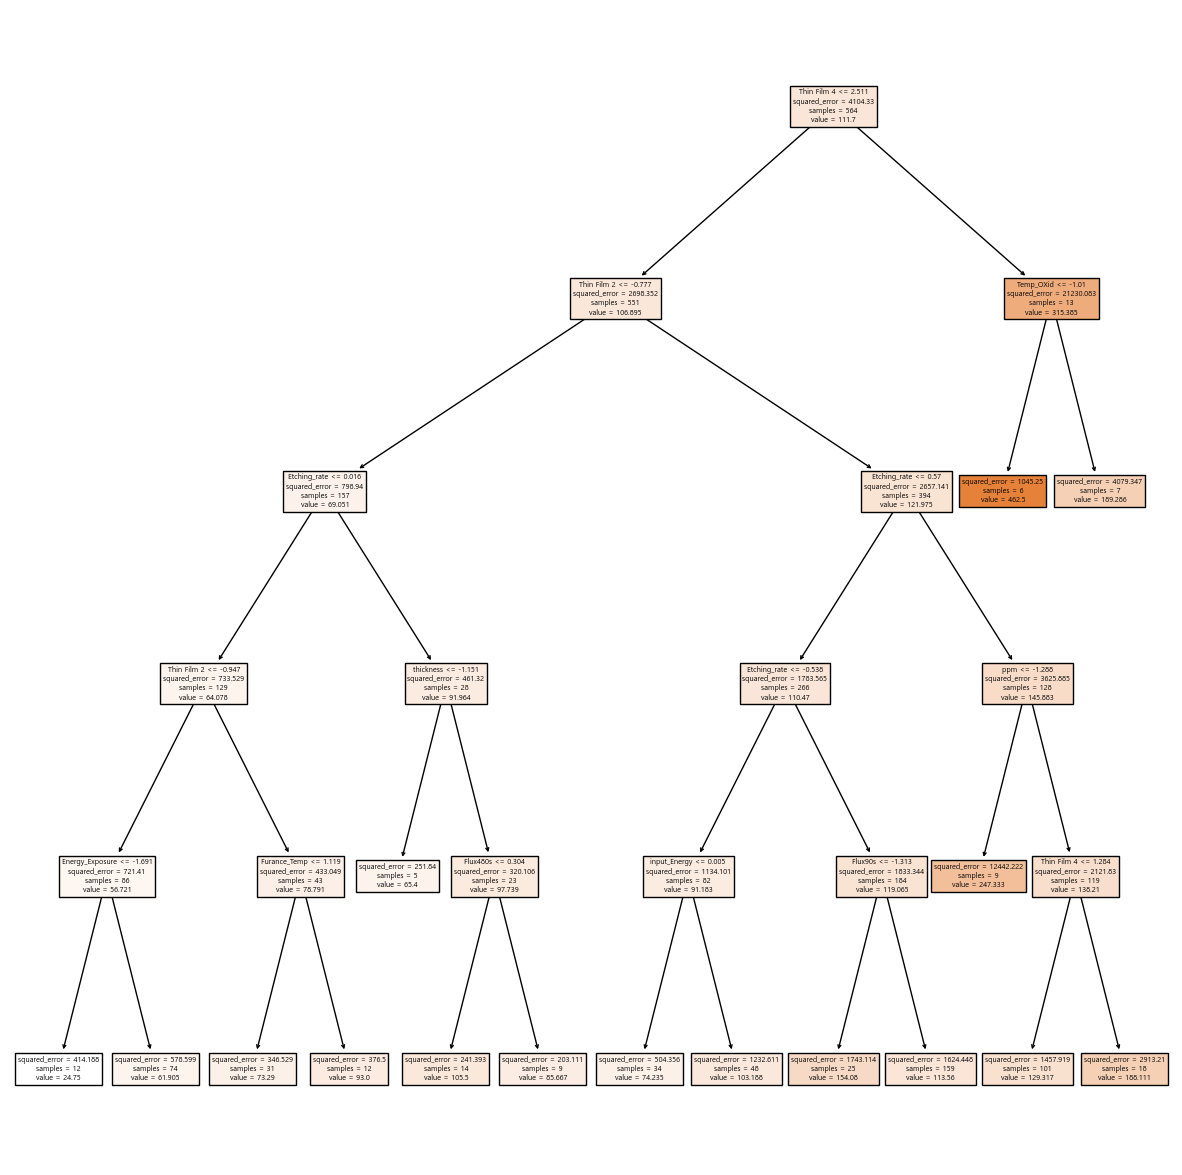

In [168]:
plt.figure(figsize=[15,15])
plot_tree(best_model['decisiontreeregressor'], filled=True,
          feature_names=X.columns.tolist())
plt.savefig('tree_result.pdf')
plt.show()


# Mission 10
- 아래의 사례들의 대해 어떤 가설 검정 기법을 써야하는지 작성하시오.
- ex. 10대와 20대의 주당방문횟수(정규성X)의 평균의 차이가 있는지 확인해야하는 상황
    -> stats.ranksums()
1. '방송구분'이라는 항목에서 '녹화방송'과 '재방송' 두 집단의 정규성을 띄지 않는 '상품주문수량'의 평균의 차이가 있는지 확인해야 하는 상황
    -> stats.ranksums()
2. 비정규 분포를 따르는 '판매단가'와 '수수료율'의 상관성을 확인해야 하는 상황
    -> stats.spearmanr()
3. '배송방식'과 '매입형태' 간의 연관성이 있는지 확인해야 하는 상황
    -> stats.chi2_contigency()
4. 정규분포를 따르며, 분산이 서로같은 '고객연령'에 대해, 고객의 주소지(3개이상) 별 연령의 평균이 차이가 있는지 확인해야 하는 상황
    -> stats.f_oneway()
5. 정규분포를 따르며, 분산이 서로 다른 '프로그램' 3종류에 따라 '매출액'의 평균이 다른지 확인해야하는 상황
    -> stats.kruskal()

- 아래의 df1 데이터를 이용하여 아래의 문제를 해결
1. 데이터 구조와 타입을 확인하고, 결측값을 각 항목 별 결측값의 개수를 확인하시오.
2. '방송구분'에서 '녹화방송'에 해당하는 데이터만 뽑아서, '상품목표주문금액'의 평균과 중앙값의 차이를 계산하시오
3. '상품주문금액'과 '상품목표주문금액'의 차이를 계산하여 '영업이익' 항목을 생성
4. '방송시작시간' 데이터로부터, 연도/월/요일 을 생성
5. '방송구분'에 따른 '연도'별 '영업이익'의 증감율을 계산
6. '방송시작시간'과 '방송종료시간'의 차이를 계산하여 '방송소요시간' 항목을 생성
7. '방송소요시간'이 가장 오래걸린 상위 10개의 광고 품목을 확인
8. '프로그램명' 항목에서 빈도수가 1000건 이상인 데이터만 추출하여, '방송구분' 별 '상품주문금액' 과 '영업이익'의 합을 계산하시오
9. '방송구분'에서 '생방송'과 '녹화방송'의 매출의 차이를 비교하고자 한다.
    - '영업이익'의 정규성을 확인
    - '생방송'과 '녹화방송' 집단의 '영업이익'의 평균의 차이가 있는지 가설검정을 수행하십시오.
10. '방송구분'에서 '녹화방송'에 해당하는 데이터만 추출하여, '영업이익'항목에 대해 RobustScaling을 수행하고, 스케일링 된 '영업이익'의 최대값을 계산하시오.
11. '영업이익'이 양수이면 1 / 음수이면 0으로 변환하여 'Target'항목으로 생성
12. '소요분' / '상품방송순번' / '판매단가' / '수수료율' / 'ARS금액'을 입력했을 때, 'Target'을 분류하는 분류 모델을 생성
13. '매입형태'와 '매입과세구분'의 연관성이 있는지 가설검정을 수행

In [169]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy.stats as stats

mpl.rc('font', family='Malgun Gothic')

In [171]:
df1 = pd.read_csv('12_Data.csv')

## 1번

In [178]:
# 1. 데이터 구조와 타입을 확인하고, 결측값을 각 항목 별 결측값의 개수를 확인하시오.
df1.info()
df1.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26283 entries, 0 to 26282
Data columns (total 25 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   방송Code    26283 non-null  float64
 1   채널        26283 non-null  object 
 2   소요분       26283 non-null  float64
 3   가중분       26283 non-null  float64
 4   방송구분      26283 non-null  object 
 5   프로그램명     26283 non-null  object 
 6   상품ID      26283 non-null  int64  
 7   상품명       26283 non-null  object 
 8   매입과세구분    26283 non-null  object 
 9   상품목표취급금액  26283 non-null  int64  
 10  상품목표주문금액  26283 non-null  int64  
 11  판매단가      26283 non-null  int64  
 12  수수료율      26283 non-null  float64
 13  상품주문수량    26283 non-null  int64  
 14  상품주문금액    26283 non-null  int64  
 15  상품취소수량    26283 non-null  int64  
 16  상품취소금액    26283 non-null  int64  
 17  ARS금액     26283 non-null  int64  
 18  매입형태      26283 non-null  object 
 19  배송방식      26283 non-null  object 
 20  상품소요분     26283 non-null  fl

방송Code      0
채널          0
소요분         0
가중분         0
방송구분        0
프로그램명       0
상품ID        0
상품명         0
매입과세구분      0
상품목표취급금액    0
상품목표주문금액    0
판매단가        0
수수료율        0
상품주문수량      0
상품주문금액      0
상품취소수량      0
상품취소금액      0
ARS금액       0
매입형태        0
배송방식        0
상품소요분       0
상품가중분       0
상품방송순번      0
방송시작시간      0
방송종료시간      0
dtype: int64

## 2번

In [180]:
# 2. '방송구분'에서 '녹화방송'에 해당하는 데이터만 뽑아서, '상품목표주문금액'의 평균과 중앙값의 차이를 계산하시오
cond1 = (df1['방송구분'] == '녹화방송')
df1.loc[cond1]['상품목표주문금액'].mean() - df1.loc[cond1]['상품목표주문금액'].median()

10473921.794871796

## 3번

In [182]:
# 3. '상품주문금액'과 '상품목표주문금액'의 차이를 계산하여 '영업이익' 항목을 생성
df1['영업이익'] = df1['상품주문금액'] - df1['상품목표주문금액']
df1

,방송Code,채널,소요분,가중분,방송구분,프로그램명,상품ID,상품명,매입과세구분,상품목표취급금액,상품목표주문금액,판매단가,수수료율,상품주문수량,상품주문금액,상품취소수량,상품취소금액,ARS금액,매입형태,배송방식,상품소요분,상품가중분,상품방송순번,방송시작시간,방송종료시간,영업이익
0,1.010036e+09,TV,50.0,52.7,녹화방송,재방_의류,10242138,[비지트인뉴욕콜렉션] 퓨어 캐시미어 롱코트,과세,65645345,117223831,149000,25.0,648,86284484,73,9624136,1000,위탁매입,협력사배송,50.0,52.7,1,2020-01-03T00:10,2020-01-03T01:00,-30939347
1,1.019126e+09,TV,60.0,38.1,녹화방송,재방_건강식품,10092003,[한삼인]순홍삼진(50ml*30포)*7박스+쇼7_2,과세,23774849,29178755,179000,26.0,200,32219095,16,2547305,1000,위탁매입,직택배,30.0,19.1,1,2020-01-03T01:00,2020-01-03T02:00,3040340
2,1.019226e+09,TV,60.0,38.1,녹화방송,재방_건강식품,10092743,[단품_한삼인] 순홍삼진(50ml*30포)*1박스,과세,23774849,29178755,60000,26.0,0,0,0,0,0,위탁매입,직택배,30.0,19.1,2,2020-01-03T01:00,2020-01-03T02:00,-29178755
3,1.040337e+09,TV,60.0,19.7,재방송,재방_가공농산,10295865,이상용의 우리밀 크레마롤,과세,24568911,28904601,48900,24.0,460,19860828,25,1080206,1000,위탁매입,협력사배송,60.0,19.7,1,2020-01-03T02:00,2020-01-03T03:00,-9043773
4,1.021427e+09,TV,60.0,16.1,재방송,재방_신선수산,10113666,국내산 자숙 문어슬라이스 120g*9팩,면세,20131383,24550467,49900,22.0,125,6090566,5,238512,1000,위탁매입,협력사배송,60.0,16.1,1,2020-01-03T03:00,2020-01-03T04:00,-18459901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26278,1.046263e+13,TV,60.0,94.3,생방송,가전,11179512,■연말특가■제우스커브드 UHD TV 65형,과세,92367433,151422021,649000,15.0,243,143118201,20,11783638,1000,위탁매입,협력사배송,19.9,32.6,1,2021-11-13T21:45,2021-11-13T22:45,-8303820
26279,1.046263e+13,TV,60.0,94.3,생방송,가전,11179514,2019 제우스 UHD TV 75형,과세,33698544,55243515,1289000,15.0,76,88954537,4,4683636,1000,위탁매입,협력사배송,26.7,41.9,2,2021-11-13T21:45,2021-11-13T22:45,33711022
26280,1.046263e+13,TV,60.0,94.3,생방송,가전,11179504,■연말특가■제우스커브드 UHD TV 55형,과세,17202608,28200996,449000,15.0,108,43990026,9,3667275,1000,위탁매입,협력사배송,13.4,22.7,3,2021-11-13T21:45,2021-11-13T22:45,15789030
26281,1.020263e+13,TV,60.0,91.6,재방송,재방_건강식품,11152474,[래오이경제] 흑염소진액 70ml x 120포,과세,154250864,202961664,159000,30.0,1363,195595043,27,3879990,1000,위탁매입,협력사배송,60.0,91.6,1,2021-11-13T22:45,2021-11-13T23:45,-7366621


## 4번

In [187]:
# 4. '방송시작시간' 데이터로부터, 연도/월/요일 을 생성
df1['datetime'] = pd.to_datetime(df1['방송시작시간'])
df1['연도'] = df1['datetime'].dt.year
df1['월'] = df1['datetime'].dt.month
df1['요일'] = df1['datetime'].dt.day_name()


## 5번

In [192]:
# 5. '방송구분'에 따른 '연도'별 '영업이익'의 증감율을 계산

p1 = df1.pivot_table(index='방송구분', values='영업이익',
                     columns='연도',aggfunc='sum').fillna(0)

p1['증감율'] = (p1[2021] - p1[2020]) / p1[2020]
p1

연도,2020,2021,증감율
방송구분,,,
녹화방송,-1.894549e+08,0.000000e+00,-1.000000
생방송,-3.573885e+10,-8.152800e+10,1.281215
재방송,-1.511756e+10,-1.906222e+10,0.260932


## 6번

In [200]:
# 6. '방송시작시간'과 '방송종료시간'의 차이를 계산하여 '방송소요시간' 항목을 생성
df1['방송소요시간'] = pd.to_datetime(df1['방송종료시간']) - pd.to_datetime(df1['방송시작시간'])


## 7번

In [210]:
# 7. '방송소요시간'이 가장 오래걸린 상위 10개의 광고 품목을 확인
df1.sort_values(by='방송소요시간', ascending=False).head(10)['상품명']

2215                   [S]감비천 13주분(감비천액열1주+감비천12주)_3
20257                            예다함 상조(19.06 사은품변경)
18828                                 예다함 상조(4구좌 추가)
19933                            예다함 상조(19.06 사은품변경)
21106                            예다함 상조(19.06 사은품변경)
4133                 닫음[단품]수앤진골드 NEW골든벨 24K 순금 목걸이_3
22795                          중경(임시정부) &  장가계 4박 5일
4134                  닫음[단품]수앤진골드 NEW골든벨 24K 순금 팔찌_3
4132     [특집전] 수앤진NEW골든벨 24K순금 목걸이+팔찌+1.875g 골드바세트_3
15946                                         예다함 상조
Name: 상품명, dtype: object

## 8번

In [310]:
# 8. '프로그램명' 항목에서 빈도수가 1000건 이상인 데이터만 추출하여, 
# '방송구분' 별 '상품주문금액' 과 '영업이익'의 합을 계산하시오

df_count = pd.DataFrame(df1['프로그램명'].value_counts())
cond1 = (df_count['프로그램명'] >= 1000)

list_1000 = df_count.loc[cond1].index.tolist()

cond1 =df1['프로그램명'].isin(list_1000)
df1.loc[cond1].pivot_table(index='방송구분',  values=['상품주문금액', '영업이익'], aggfunc='sum')

,상품주문금액,영업이익
방송구분,,
생방송,490453552166,-38166117445
재방송,346480899,10929779


In [302]:
df1['프로그램명'].value_counts().values
df1_list = df1['프로그램명'].value_counts().head(5).index.tolist()
cond1 = df1['프로그램명'].isin(df1_list)
df1.loc[cond1].pivot_table(index='방송구분', values=['상품주문금액', '영업이익'], aggfunc='sum')

,상품주문금액,영업이익
방송구분,,
생방송,490453552166,-38166117445
재방송,346480899,10929779


## 9번

In [254]:
# 9. '방송구분'에서 '생방송'과 '녹화방송'의 매출의 차이를 비교하고자 한다.
#     - '영업이익'의 정규성을 확인
#     - '생방송'과 '녹화방송' 집단의 '영업이익'의 평균의 차이가 있는지 가설검정을 수행하십시오.

stats.normaltest(df1['영업이익'])
# p.value < 0.05 / 대립가설 참 / 분포가 정규분포를 따르지 않는다.

NormaltestResult(statistic=22949.29534847279, pvalue=0.0)

In [256]:
cond1 = (df1['방송구분'] == '생방송')
cond2 = (df1['방송구분'] == '녹화방송')

stats.ranksums(df1.loc[cond1]['영업이익'], df1.loc[cond2]['영업이익'])
# P.value > 0.05 / 귀무가설 참 / 두 집단의 A1 값의 평균의 차이가 없다.

RanksumsResult(statistic=-1.1432589065314094, pvalue=0.2529311112195203)

## 10번

In [267]:
# 빅데이터 분석기사 문제
# 10. '방송구분'에서 '녹화방송'에 해당하는 데이터만 추출하여, '영업이익'항목에 대해 RobustScaling을 수행하고, 
# 스케일링 된 '영업이익'의 최대값을 계산하시오.

from sklearn.preprocessing import RobustScaler

cond1 = (df1['방송구분'] == '녹화방송')
df2 = df1.loc[cond1]

scaler = RobustScaler()
scaler.fit(df2[['영업이익']])

RobustScaler()

In [268]:
df_scale = pd.DataFrame(scaler.fit_transform(df2[['영업이익']]))
df_scale.max()

0    2.897498
dtype: float64

## 11번

In [269]:
# 11. '영업이익'이 양수이면 1 / 음수이면 0으로 변환하여 'Target'항목으로 생성
cond1 = (df1['영업이익'] >= 0)
df1.loc[cond1, 'Target'] = 1
df1.loc[~cond1, 'Target'] = 0
df1['Target']

0        0.0
1        1.0
2        0.0
3        0.0
4        0.0
        ... 
26278    0.0
26279    1.0
26280    1.0
26281    0.0
26282    0.0
Name: Target, Length: 26283, dtype: float64

## 12번(강사님)

In [278]:
# 12. '소요분' / '상품방송순번' / '판매단가' / '수수료율' / 'ARS금액'을 입력했을 때, 'Target'을 분류하는 분류 모델을 생성
X = df1[['소요분','상품방송순번','판매단가','수수료율', 'ARS금액']]
Y = df1['Target']


In [313]:
from sklearn.model_selection import train_test_split
from imblearn.pipeline import make_pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.tree   import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV


In [314]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, random_state=1234)


In [317]:
model_pipe = make_pipeline(KNNImputer(), StandardScaler()
                            , DecisionTreeClassifier())

hyperparameter_list = {'decisiontreeclassifier__max_depth' : range(5,11)
                        , 'decisiontreeclassifier__min_samples_split' : range(5,11)
                        , 'decisiontreeclassifier__min_samples_leaf' : range(5,11)}

grid_model = GridSearchCV(model_pipe, cv=5, param_grid={}, scoring='f1', n_jobs=-1)
grid_model.fit(X_train, Y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('knnimputer', KNNImputer()),
                                       ('standardscaler', StandardScaler()),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier())]),
             n_jobs=-1, param_grid={}, scoring='f1')

In [319]:
best_model = grid_model.best_estimator_

In [320]:
# 평가
from sklearn.metrics import classification_report

In [323]:
def evaluation_func_class(best_model) :
    Y_train_pred = best_model.predict(X_train)
    Y_test_pred = best_model.predict(X_test)
    print('학습능력평가')
    print(classification_report(Y_train, Y_train_pred))
    print('일반화능력평가')
    print(classification_report(Y_test, Y_test_pred))

In [324]:
evaluation_func_class(best_model)

학습능력평가
              precision    recall  f1-score   support

         0.0       0.82      0.96      0.89     12204
         1.0       0.91      0.66      0.77      7508

    accuracy                           0.85     19712
   macro avg       0.87      0.81      0.83     19712
weighted avg       0.86      0.85      0.84     19712

일반화능력평가
              precision    recall  f1-score   support

         0.0       0.70      0.81      0.75      4129
         1.0       0.56      0.42      0.48      2442

    accuracy                           0.66      6571
   macro avg       0.63      0.61      0.62      6571
weighted avg       0.65      0.66      0.65      6571



## 12번

In [311]:
# 12. '소요분' / '상품방송순번' / '판매단가' / '수수료율' / 'ARS금액'을 입력했을 때, 'Target'을 분류하는 분류 모델을 생성

In [312]:
from sklearn.model_selection import train_test_split    # 학습데이터와 검증데이터 분할
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

In [279]:
# X, Y 값 설정하기
X = df1[['소요분', '상품방송순번','판매단가', '수수료율', 'ARS금액']]
Y = df1['Target']

In [287]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26283 entries, 0 to 26282
Data columns (total 32 columns):
 #   Column    Non-Null Count  Dtype          
---  ------    --------------  -----          
 0   방송Code    26283 non-null  float64        
 1   채널        26283 non-null  object         
 2   소요분       26283 non-null  float64        
 3   가중분       26283 non-null  float64        
 4   방송구분      26283 non-null  object         
 5   프로그램명     26283 non-null  object         
 6   상품ID      26283 non-null  int64          
 7   상품명       26283 non-null  object         
 8   매입과세구분    26283 non-null  object         
 9   상품목표취급금액  26283 non-null  int64          
 10  상품목표주문금액  26283 non-null  int64          
 11  판매단가      26283 non-null  int64          
 12  수수료율      26283 non-null  float64        
 13  상품주문수량    26283 non-null  int64          
 14  상품주문금액    26283 non-null  int64          
 15  상품취소수량    26283 non-null  int64          
 16  상품취소금액    26283 non-null  int64         

In [280]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, random_state = 1234)

In [293]:
from sklearn.tree import DecisionTreeClassifier

numeric_pipe = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())
numeric_list = X.describe().columns.tolist()

preprocessing_pipe = make_column_transformer((numeric_pipe, numeric_list))
model_pipe = make_pipeline(preprocessing_pipe, DecisionTreeClassifier())
model_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['소요분', '상품방송순번', '판매단가',
                                                   '수수료율', 'ARS금액'])])),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

In [294]:
grid_model = GridSearchCV(model_pipe, cv=3, param_grid={}, n_jobs=-1)
grid_model.fit(X_train, Y_train)
best_model = grid_model.best_estimator_
best_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['소요분', '상품방송순번', '판매단가',
                                                   '수수료율', 'ARS금액'])])),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

In [295]:
Y_train_pred = best_model.predict(X_train)
Y_test_pred  = best_model.predict(X_test)

In [298]:
# sklearn.metrics : 평가지표들을 확인
from sklearn.metrics import classification_report

# 예측값과 실제값을 비교해 평가
from sklearn.metrics import accuracy_score

In [299]:
accuracy_score(Y_test, Y_test_pred)

0.6650433723938518

In [300]:
# 학습 능력 평가
accuracy_score(Y_train, Y_train_pred)

0.846387987012987

In [301]:
print(classification_report(Y_test, Y_test_pred))

              precision    recall  f1-score   support

         0.0       0.70      0.81      0.75      4129
         1.0       0.57      0.42      0.48      2442

    accuracy                           0.67      6571
   macro avg       0.63      0.62      0.62      6571
weighted avg       0.65      0.67      0.65      6571



## 13번

In [277]:
# 13. '매입형태'와 '매입과세구분'의 연관성이 있는지 가설검정을 수행

df1_table = pd.crosstab(df1['매입형태'], df1['매입과세구분'])
stats.chi2_contingency(df1_table)
# 통계량 / P.value / 자유도 / 기댓값
# P.value < 0.05 대립가설 참 / 고객의 등급과 제품군 간의 연관성이 있다.

(186.52831987660014,
 1.8203703751506522e-42,
 1,
 array([[20743.3367576,  4520.6632424],
        [  836.6632424,   182.3367576]]))